In [0]:
import numpy as np
import os
from keras.applications.xception import Xception,preprocess_input
from PIL import Image
import os
import sys
import random
import warnings

import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from skimage import exposure
import pandas as pd

from skimage.transform import resize
from skimage.morphology import label
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [0]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
model_1=Xception(weights='imagenet',include_top=False)
model_2=VGG16(weights='imagenet',include_top=False)



In [0]:
print(model_1.summary())

In [51]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)    
    img = preprocess_input(img)
    return img


K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
# model = inception_v3.InceptionV3(weights='imagenet',
#                                  include_top=False)
model = Xception(weights='imagenet',include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# you can play with different settings...
settings = {
    'features': {
        'block2_pool':0.4,
        'block3_pool':0.1,
    },
}

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
#         print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

Model loaded.


In [52]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 100  # Number of ascent steps per scale
max_loss = 10.

ids = os.listdir('/content/')
np.random.seed(42)
idx = np.random.randint(0, len(ids)//5)
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0)  #adjust this to change vertical and horiz. spacings..
nImg = 3  #no. of images to process
processed_img = []
orig_img = []
counter = 0
j = 0

    
base_image_path = '1.jpg'
img = image.load_img(base_image_path)
img = image.img_to_array(img)
t = img.copy()
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

original_shape = img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
  successive_shapes = successive_shapes[::-1]
  original_img = np.copy(img)
  shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)    
  processed_img.append(img)
  orig_img.append(t)

Processing image shape (261, 173)
Processing image shape (512, 341)
Processing image shape (365, 243)


<Figure size 2160x1080 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


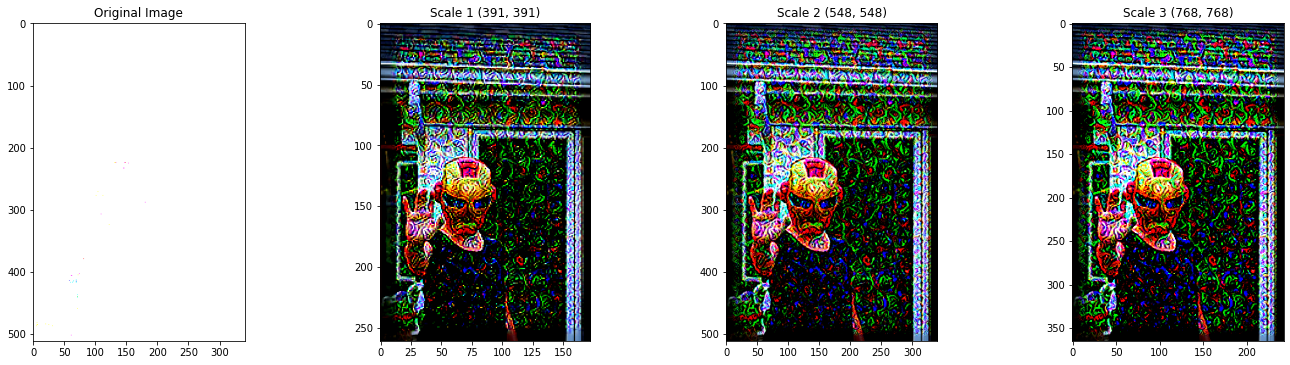

In [54]:
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=1.2)  #adjust this to change vertical and horiz. spacings..
for i in range(1):
    q  = i + 1
    plt.subplot(nImg,5,q*5-4)
    img = orig_img[i]
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(nImg,5,q*5-3)
    img = processed_img[i*3]
    plt.imshow(exposure.rescale_intensity(img[0,:,:,:],in_range=(0,1)))
    plt.title('Scale 1 (391, 391)')
    
    plt.subplot(nImg,5,q*5-2)
    img = processed_img[i*3+1]
    plt.imshow(exposure.rescale_intensity(img[0,:,:,:],in_range=(0,1)))
    plt.title('Scale 2 (548, 548)')
    
    plt.subplot(nImg,5,q*5-1)
    img = processed_img[i*3+2]
    plt.imshow(exposure.rescale_intensity(img[0,:,:,:],in_range=(0,1)))
    plt.title('Scale 3 (768, 768)')